In [56]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, skewness, count, mean, stddev, isnan, lit, col,sum as spark_sum
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

#visualization libraries
import matplotlib.pyplot as plt
#importing pandas to plot in matplotlib
import pandas as pd

# 1. Initialize Spark
spark = SparkSession.builder.appName("HMDA_Preprocessing").getOrCreate()


# 2. Load data with 5000 sample rows
df = spark.read.csv("hmda_2016_sample.csv", header=True, inferSchema=True)
print("Initial data shape:", (df.count(), len(df.columns)))


# 3. Target variable transformation  "action_taken_name" 

df = df.withColumn("target", when(col("action_taken_name") == "Loan originated", 1).otherwise(0))
df = df.drop("action_taken_name")

# 4. Handle nulls 

numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float')]
for c in numeric_cols:
    df = df.withColumn(c, when(isnan(col(c)) | col(c).isNull(), None).otherwise(col(c)))

# Compute skewness for numeric columns
skew_data = df.select([skewness(col(c)).alias(c) for c in numeric_cols]).collect()[0].asDict()
print("Skewness:", skew_data)

# Impute based on skewness
# For right-skewed columns → median, for left-skewed → mean
for c in numeric_cols:
    col_skew = skew_data[c]
    if col_skew is not None:
        if abs(col_skew) > 1:
            # Median imputation for skewed data
            median_val = df.approxQuantile(c, [0.5], 0.01)[0]
            df = df.na.fill({c: median_val})
        else:
            # Mean imputation otherwise
            mean_val = df.select(F.mean(col(c))).first()[0]
            df = df.na.fill({c: mean_val})


# 5. Remove outliers (using IQR)

for c in numeric_cols:
    try:
        quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
        if len(quantiles) < 2:
            print(f"Skipping {c} - insufficient data for IQR")
            continue

        q1, q3 = quantiles
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df.filter((col(c) >= lower) & (col(c) <= upper))
    except Exception as e:
        print(f"Skipping {c} due to error: {e}")
        continue

# 6. Remove zero-variance and near-zero variance columns

stats = df.select([(F.variance(col(c)).alias(c)) for c in numeric_cols]).collect()[0].asDict()
low_var_cols = [c for c, v in stats.items() if v is None or v < 1e-5]
df = df.drop(*low_var_cols)
print("Removed low variance columns:", low_var_cols)


# 7. Remove highly correlated attributes

remaining_numeric = [c for c in df.columns if c in numeric_cols and c not in low_var_cols]

assembler = VectorAssembler(inputCols=remaining_numeric, outputCol="features")
df_vec = assembler.transform(df).select("features")

corr_matrix = Correlation.corr(df_vec, "features").head()[0].toArray()

# Drop one of each pair of highly correlated columns
to_drop = set()
for i in range(len(remaining_numeric)):
    for j in range(i + 1, len(remaining_numeric)):
        if abs(corr_matrix[i][j]) > 0.9:
            to_drop.add(remaining_numeric[j])
df = df.drop(*list(to_drop))
print("Dropped highly correlated columns:", list(to_drop))


print("Data shape:", (df.count(), len(df.columns)))
df.show(5)


Initial data shape: (5000, 78)
Skewness: {'as_of_year': None, 'agency_code': -1.133557610752084, 'loan_type': 1.545307862548966, 'property_type': 6.477759409275815, 'loan_purpose': -0.06631160538001363, 'owner_occupancy': 3.2692081888329367, 'loan_amount_000s': 13.246193188807139, 'preapproval': -2.704683294662515, 'action_taken': 0.7926353514882726, 'msamd': -0.1740281799089542, 'state_code': 0.1789081233380773, 'county_code': 3.2814795595246715, 'census_tract_number': 1.367942936743142, 'applicant_ethnicity': 1.0546734106604552, 'co_applicant_ethnicity': -0.44057157346257925, 'applicant_race_1': -0.8732381845762832, 'applicant_race_2': -1.1860104552658883, 'applicant_race_3': None, 'co_applicant_race_1': -0.9055591729925622, 'co_applicant_race_2': -1.9388768742861848, 'applicant_sex': 1.2990363212262155, 'co_applicant_sex': -0.45824476121158225, 'applicant_income_000s': 10.299430074770887, 'purchaser_type': 1.617201818252887, 'denial_reason_1': 0.6015422614842352, 'denial_reason_2': 

In [57]:

# Get null counts for each column
null_counts = []
for column_name in df.columns:
    null_count = df.filter(col(column_name).isNull()).count()
    null_counts.append((column_name, null_count))

# Display results
print("Null/Missing Values Count by Column:")
print("-" * 50)
for column_name, count in null_counts:
    print(f"{column_name}: {count}")

# Also check for NaN values in numeric columns
print("\nNaN Values Count by Column:")
print("-" * 50)
for column_name, count in null_counts:
    if column_name in [c for c, t in df.dtypes if t in ('int', 'double', 'float')]:
        nan_count = df.filter(isnan(col(column_name))).count()
        if nan_count > 0:
            print(f"{column_name}: {nan_count}")

# Summary statistics
total_nulls = sum([count for _, count in null_counts])
print(f"\nTotal null/missing values across all columns: {total_nulls}")
# print(f"Columns with nulls: {len([name for name, count in null_counts if count > 0])}")
# print(f"Columns without nulls: {len([name for name, count in null_counts if count == 0])}")


Null/Missing Values Count by Column:
--------------------------------------------------
respondent_id: 0
agency_name: 0
agency_abbr: 0
agency_code: 0
loan_type_name: 0
loan_type: 0
property_type_name: 0
loan_purpose_name: 0
loan_purpose: 0
owner_occupancy_name: 0
loan_amount_000s: 0
preapproval_name: 0
action_taken: 0
msamd_name: 8
msamd: 0
state_name: 2
state_abbr: 2
state_code: 0
county_name: 2
county_code: 0
census_tract_number: 0
applicant_ethnicity_name: 0
co_applicant_ethnicity_name: 0
co_applicant_ethnicity: 0
applicant_race_name_1: 0
applicant_race_name_2: 120
applicant_race_name_3: 120
applicant_race_name_4: 120
applicant_race_4: 120
applicant_race_name_5: 120
applicant_race_5: 120
co_applicant_race_name_1: 0
co_applicant_race_name_2: 120
co_applicant_race_name_3: 120
co_applicant_race_3: 120
co_applicant_race_name_4: 120
co_applicant_race_4: 120
co_applicant_race_name_5: 120
co_applicant_race_5: 120
applicant_sex_name: 0
applicant_sex: 0
co_applicant_sex_name: 0
applicant_inc

In [58]:
# Calculate total number of rows
total_rows = df.count()
print(f"Total rows in dataset: {total_rows}")

# Define threshold for majority (50% or more)
threshold = 0.7
majority_threshold = total_rows * threshold

print(f"Majority threshold (70% of {total_rows} rows): {majority_threshold}")

# Find columns with majority null/missing values
columns_to_drop = []
null_analysis = []

for column_name in df.columns:
    # Count null values
    null_count = df.filter(col(column_name).isNull()).count()
    
    # Count NaN values for numeric columns
    nan_count = 0
    if column_name in [c for c, t in df.dtypes if t in ('int', 'double', 'float')]:
        nan_count = df.filter(isnan(col(column_name))).count()
    
    # Total missing values
    total_missing = null_count + nan_count
    missing_percentage = (total_missing / total_rows) * 100
    
    null_analysis.append({
        'column': column_name,
        'null_count': null_count,
        'nan_count': nan_count,
        'total_missing': total_missing,
        'missing_percentage': missing_percentage
    })
    
    # Check if majority is missing
    if total_missing >= majority_threshold:
        columns_to_drop.append(column_name)

# Display analysis
print("\nMissing Values Analysis:")
print("-" * 80)
print(f"{'Column':<30} {'Nulls':<8} {'NaNs':<8} {'Total':<8} {'% Missing':<10} {'Action'}")
print("-" * 80)

for analysis in null_analysis:
    action = "DROP" if analysis['column'] in columns_to_drop else "KEEP"
    print(f"{analysis['column']:<30} {analysis['null_count']:<8} {analysis['nan_count']:<8} {analysis['total_missing']:<8} {analysis['missing_percentage']:<10.2f} {action}")

# Drop columns with majority missing values
if columns_to_drop:
    print(f"\nDropping {len(columns_to_drop)} columns with majority missing values:")
    for col in columns_to_drop:
        print(f"  - {col}")
    
    df = df.drop(*columns_to_drop)
    print(f"\nDataset shape after dropping columns: {df.count()} rows, {len(df.columns)} columns")
else:
    print("\nNo columns found with majority missing values.")

# Show remaining columns
# print(f"\nRemaining columns ({len(df.columns)}):")
# for i, col in enumerate(df.columns, 1):
#     print(f"{i:2d}. {col}")


Total rows in dataset: 120
Majority threshold (70% of 120 rows): 84.0

Missing Values Analysis:
--------------------------------------------------------------------------------
Column                         Nulls    NaNs     Total    % Missing  Action
--------------------------------------------------------------------------------
respondent_id                  0        0        0        0.00       KEEP
agency_name                    0        0        0        0.00       KEEP
agency_abbr                    0        0        0        0.00       KEEP
agency_code                    0        0        0        0.00       KEEP
loan_type_name                 0        0        0        0.00       KEEP
loan_type                      0        0        0        0.00       KEEP
property_type_name             0        0        0        0.00       KEEP
loan_purpose_name              0        0        0        0.00       KEEP
loan_purpose                   0        0        0        0.00       KEEP


In [59]:
print("Final shape:", (df.count(), len(df.columns)))
df.show(5)

Final shape: (120, 42)
+-------------+--------------------+-----------+-----------+--------------+---------+--------------------+-----------------+------------+--------------------+----------------+----------------+------------+--------------------+-----------------+----------+----------+----------+-----------------+-----------+-------------------+------------------------+---------------------------+----------------------+---------------------+------------------------+------------------+-------------+---------------------+---------------------+--------------------+--------------+-----------------+--------------------+--------------------+---------------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+
|respondent_id|         agency_name|agency_abbr|agency_code|loan_type_name|loan_type|  property_type_name|loan_purpose_name|loan_purpose|owner_occupancy_name|loan_amount_000s|preapproval_name|action

In [60]:
df.columns

['respondent_id',
 'agency_name',
 'agency_abbr',
 'agency_code',
 'loan_type_name',
 'loan_type',
 'property_type_name',
 'loan_purpose_name',
 'loan_purpose',
 'owner_occupancy_name',
 'loan_amount_000s',
 'preapproval_name',
 'action_taken',
 'msamd_name',
 'msamd',
 'state_name',
 'state_abbr',
 'state_code',
 'county_name',
 'county_code',
 'census_tract_number',
 'applicant_ethnicity_name',
 'co_applicant_ethnicity_name',
 'co_applicant_ethnicity',
 'applicant_race_name_1',
 'co_applicant_race_name_1',
 'applicant_sex_name',
 'applicant_sex',
 'co_applicant_sex_name',
 'applicant_income_000s',
 'purchaser_type_name',
 'purchaser_type',
 'hoepa_status_name',
 'lien_status_name',
 'edit_status_name',
 'sequence_number',
 'population',
 'minority_population',
 'hud_median_family_income',
 'tract_to_msamd_income',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units']

In [61]:
# the target column was droped, so I will create it again
df = df.withColumn('target',
                   F.when(df['action_taken'] == 1, 1).otherwise(0)
                  )
# we want to remove action_taken here, when we run the information gain, 
# it will only look at that column and our other features would not allow for 
# us to see the importance of that column

df = df.drop('action_taken')
df.columns

['respondent_id',
 'agency_name',
 'agency_abbr',
 'agency_code',
 'loan_type_name',
 'loan_type',
 'property_type_name',
 'loan_purpose_name',
 'loan_purpose',
 'owner_occupancy_name',
 'loan_amount_000s',
 'preapproval_name',
 'msamd_name',
 'msamd',
 'state_name',
 'state_abbr',
 'state_code',
 'county_name',
 'county_code',
 'census_tract_number',
 'applicant_ethnicity_name',
 'co_applicant_ethnicity_name',
 'co_applicant_ethnicity',
 'applicant_race_name_1',
 'co_applicant_race_name_1',
 'applicant_sex_name',
 'applicant_sex',
 'co_applicant_sex_name',
 'applicant_income_000s',
 'purchaser_type_name',
 'purchaser_type',
 'hoepa_status_name',
 'lien_status_name',
 'edit_status_name',
 'sequence_number',
 'population',
 'minority_population',
 'hud_median_family_income',
 'tract_to_msamd_income',
 'number_of_owner_occupied_units',
 'number_of_1_to_4_family_units',
 'target']

In [62]:
target_count = df.groupBy('target').count()
target_count.show()

+------+-----+
|target|count|
+------+-----+
|     1|   79|
|     0|   41|
+------+-----+



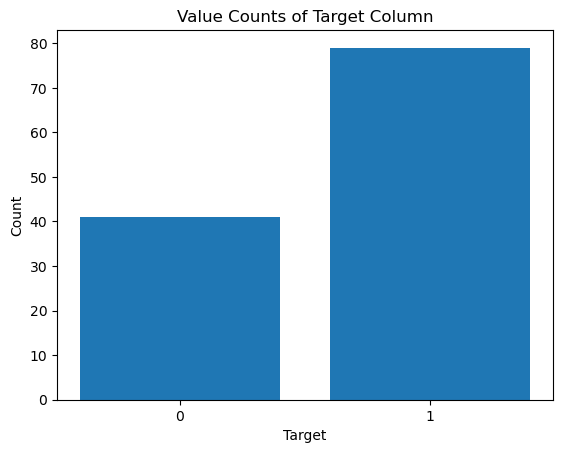

In [63]:
target_count_pandas = target_count.toPandas()
plt.bar(target_count_pandas['target'], target_count_pandas['count'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Value Counts of Target Column')
plt.xticks([0,1])
plt.show()

SMOTE in PySpark Article: https://medium.com/data-and-beyond/exploring-pyspark-ml-for-machine-learning-handling-class-imbalances-part-2-2-f9113f6b40ba

In [64]:
num_cols = len(df.columns)
print(num_cols)

42


In [65]:
# checking the schema to see what colums we currently have
df.printSchema()

root
 |-- respondent_id: string (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- agency_abbr: string (nullable = true)
 |-- agency_code: integer (nullable = true)
 |-- loan_type_name: string (nullable = true)
 |-- loan_type: integer (nullable = true)
 |-- property_type_name: string (nullable = true)
 |-- loan_purpose_name: string (nullable = true)
 |-- loan_purpose: integer (nullable = true)
 |-- owner_occupancy_name: string (nullable = true)
 |-- loan_amount_000s: integer (nullable = true)
 |-- preapproval_name: string (nullable = true)
 |-- msamd_name: string (nullable = true)
 |-- msamd: double (nullable = false)
 |-- state_name: string (nullable = true)
 |-- state_abbr: string (nullable = true)
 |-- state_code: double (nullable = false)
 |-- county_name: string (nullable = true)
 |-- county_code: double (nullable = false)
 |-- census_tract_number: double (nullable = false)
 |-- applicant_ethnicity_name: string (nullable = true)
 |-- co_applicant_ethnicity_name: str

## Implement Smote in PySpark

Pros: 
- We could learn how to implement it ourselves
Cons: 
- PySpark does not natively include oversampling techniques like SMOTE
- Complex to implement and resource intensive (memory could explode when creating synthetic rows)
- Will take much longer to implement (time crunch)

## SMOTE PySpark + Pandas
Pros: 
- FULL use of SMOTE style oversampling
- parallelizable (each workinger handls part of the data)
- Preserves pyspark scalability 
Cons: 
- Implementation can by tricky, we have to be careful how we partition the data
- MUCH MORE memory expensive than random oversampling
- requires some memory on each executor to hold chucks of data in pandas form (we can broadcast this part to make optimize it)
- We would have to transfor the data from PySpark dataframes to pandas dataframes to Pyspark dataframes again

## Classic Oversampling in PySpark
Pros: 
- We can manually oversample the minority class by duplicatin existing rows
- Much simpler than implementing SMOTE by hand
- Scales perfectly with PySpark
- Stable for datasets in the GB range
- Keeps spark partitions distributed
Cons:
- Does not create new data points, it just duplicates them
- May lead to overfitting if minority class is small and highly redundant

## Perform undersampling
Pros:
- Fast processing, we will match the minority class
- No overfiting risk
- Lower computational cost
- Simple implementation

Cons:
- We lose alot of information when we cut down rows to match the minority class
- the model might not be able to generalize well if the remaning majority class looks very similar
- We need to keep results the same, so we need to use a seed
- It could create bias towards certain results, we will need to undersample randomly.



We are going to try classic oversampling and undersampling to see how things work 

In [78]:
#let's start by separaing the minoir
minority_df = df.filter(F.col('target')== 0)
majority_df = df.filter(F.col('target')== 1)

minority_count = minority_df.count()
majority_count = majority_df.count()

# lets see the ratio of the majority and mayority
ratio = majority_count/minority_count
print(F"Ratio: {ratio:.2f}")
# We are randombly sampling with replacement from the minority class
# to match the majority class
oversampled_minority = minority_df.sample(withReplacement = True, fraction = ratio, seed = 42)

# Now let's combine the oversampled minority data with original majority data
oversampled_df = majority_df.union(oversampled_minority)

## we are going to shuffle so the data can be randombly separated
oversampled_df = oversampled_df.orderBy(F.rand(seed = 42))

## Check results
oversampled_df.groupBy('target').count().show()
# oversampled_df.printSchema()

Ratio: 1.93
+------+-----+
|target|count|
+------+-----+
|     1|   79|
|     0|   77|
+------+-----+



In [79]:
# let's try doing undersampling 
# First, we are going to calculate the undersampling ratio to see by how much we need to increase
# undersample_ratio = minority_count / majority_count
undersample_ratio = .60

print("Undersample Ratio: ", undersample_ratio)
# then we are going to randomly sample the majority class without replacemment!
# this will allow us to match the minority size
undersampled_majority = majority_df.sample(withReplacement = False, fraction = undersample_ratio, seed=42)

# combining the reduced majority class with the full minority class
undersampled_df = undersampled_majority.union(minority_df)

# shuffle the dataset so we don't get clusters and reduce bias
undersampled_df = undersampled_df.orderBy(F.rand(seed =42))

#check balance
undersampled_df.groupBy('target').count().show()

Undersample Ratio:  0.6
+------+-----+
|target|count|
+------+-----+
|     1|   40|
|     0|   41|
+------+-----+



## Information Gain Step:

- We are going to use a decision tree and entropy to undersatnd which features are the most important when creating a ML model. This step will help us run our random forest algorightm to predict if a loan was originated.
  

In [80]:
# Lets select our target variable and the features we are using to predict it

target_col = 'target'

# columns that we have that do provide any predictive power or they threw an error later
# county_name and msamd_name have 54 and 66 different distinct values in ther columns
# error: requirement failed: DecisionTree requires maxBins (= 32) to be at least as 
# large as the number of values in each categorical feature, but categorical feature 7 has 34 values
# state_name: 35 distinct values
# state_abbr: 35 distinct values

exclude_cols = ['respondent_id', 'edit_status_name', 'county_name', 'msamd_name', 'state_name', 'state_abbr']

# identifying categorical and numeric columns 
categorical_columns = [
    column_name for column_name, data_type in undersampled_df.dtypes
    if data_type == 'string'
    and column_name not in exclude_cols + [target_col] #excluding ID and label columns
]

numeric_columns = [
    column_name for column_name, data_type in undersampled_df.dtypes
    if data_type != 'string' # not a string
    and column_name not in exclude_cols + [target_col] #exclude Id and label columns   
]

# Now the goal is to convert categorical columns to numeric columns through indexes and then we will convert them into vectors
# for our machine learning model to compare and see which column provides the most information gain

string_indexers = [
    StringIndexer(
        inputCol = categorical_column, # referencing the categorical columns array from above
        outputCol = f"{categorical_column}_indexed", #new numeric column names
        handleInvalid = 'skip' # skip rows that have nulls
    )
    for categorical_column in categorical_columns
]

# Combining our numerical and cathegorical features as a vector 

final_feature_columns = [f"{categorical_column}_indexed" for categorical_column in categorical_columns] + numeric_columns

# now the Vector assembler unites all the feature columns into one vector column 

feature_assembler = VectorAssembler(
    inputCols = final_feature_columns,
    outputCol = 'features'
)

# now that we have our vectors in one variable, we can finaly use or decision tree classifier
# the decision tree will evaluate each feature's ability to split the data based on our target variable.
# The entropy will measure the purity of the result
# Source: https://www.geeksforgeeks.org/data-science/how-to-calculate-entropy-in-decision-tree/
# Understanding Entropy
# Entropy is a measure of uncertainty or disorder. 
# In the terms of decision trees, it helps us understand how mixed the data is. 
#If all instances in a dataset belong to one class, entropy is zero, meaning the data is perfectly pure. 
# On the other hand, when the data is evenly distributed across multiple classes, entropy is maximum, indicating high uncertainty.

decision_tree_classifer = DecisionTreeClassifier(
    labelCol = target_col, # target column
    featuresCol = 'features', # vector column from the assembler that we created previosly
    impurity = 'entropy', # using entropy to measure information gain
    maxDepth = 10 #how deep the tree can grow, we don't want a super deep tree because it will take a lot of resources when we run 
                # in the cloud.
)

information_gain_pipeline = Pipeline(
    stages = string_indexers + [feature_assembler, decision_tree_classifer]
)

# lets fit the model with the information we created from the under sampled dataframe
# and extract the trained decision tree model 
fitted_model_undersampled = information_gain_pipeline.fit(undersampled_df)
decision_tree_model_undersampled = fitted_model_undersampled.stages[-1]

# same step, but we the oversampled data
fitted_model_oversampled = information_gain_pipeline.fit(oversampled_df)
decision_tree_model_oversampled = fitted_model_oversampled.stages[-1]

# getting the feature names used by the model
feature_names = final_feature_columns

information_gain_undersampled = (
    decision_tree_model_undersampled.featureImportances.toArray().tolist()
)

information_gain_oversampled = (
    decision_tree_model_oversampled.featureImportances.toArray().tolist()
)


In [81]:
# Let's transform our results from spark to pandas so we can use matplotlib to create a graph
feature_importance_undersampled_df = pd.DataFrame({
    'Feature': feature_names,
    'Information_Gain': information_gain_undersampled
}).sort_values('Information_Gain', ascending= False)

feature_importance_oversampled_df = pd.DataFrame({
    'Feature':feature_names,
    'Information_Gain': information_gain_oversampled
}).sort_values('Information_Gain', ascending = False)

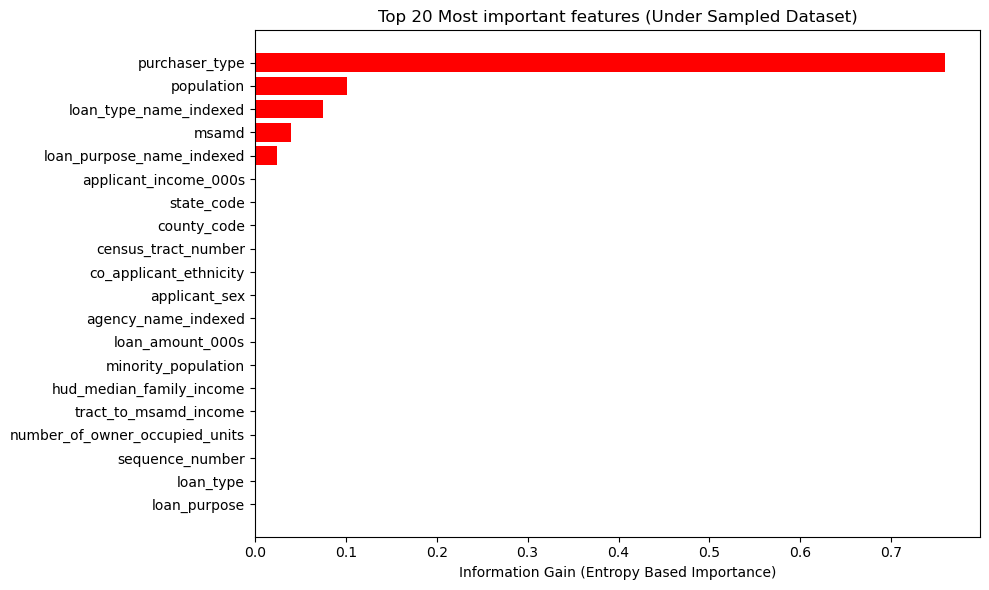

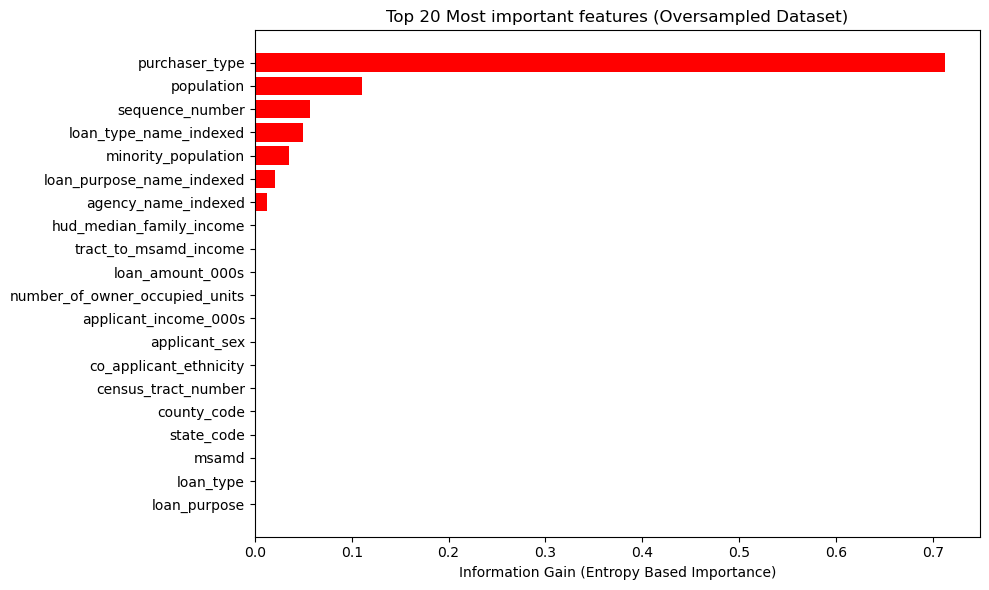

In [82]:
# let's graph our results

def plot_information_gain(df, title):
    top_features = df.head(20)

    # creating a horizontal bar chart to have a better view 
    plt.figure(figsize = (10,6))
    plt.barh(top_features['Feature'], top_features['Information_Gain'], color = 'red')
    plt.xlabel('Information Gain (Entropy Based Importance)')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_information_gain(feature_importance_undersampled_df, 'Top 20 Most important features (Under Sampled Dataset)')
plot_information_gain(feature_importance_oversampled_df, 'Top 20 Most important features (Oversampled Dataset)')


In [83]:
undersampled_df.select("applicant_income_000s").describe().show()

+-------+---------------------+
|summary|applicant_income_000s|
+-------+---------------------+
|  count|                   81|
|   mean|     83.8641975308642|
| stddev|   24.020695809249446|
|    min|                 24.0|
|    max|                165.0|
+-------+---------------------+

